<a href="https://colab.research.google.com/github/danielvijill/nrao-nine-2024/blob/main/NGC5258_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NRAO NINE 2024

---



#NGC5258 Data Analysis Tutorial

by [Daniel Argueta Vijil](https://astrohn.wixsite.com/danielvijil)$^1$ and [Alejandro Saravia](https://astronomy.as.virginia.edu/alejandro-saravia)$^2$

$^1$*Universidad Nacional Autónoma de Honduras, Tegucigalpa, Honduras*

$^2$*University of Virginia, Charlottesville VA, USA*


## Import python packages

In this tutorial we will be making use of the following libraries


*   [Astropy](https://learn.astropy.org/) (version 5.3): basic astronomy utilities
*   [Pyregion](https://pyregion.readthedocs.io/en/latest/): to parse ds9 region files
*   [Photutils](https://photutils.readthedocs.io/en/stable/): to perform photometry on images
*   [Regions](https://pypi.org/project/regions/): another package for regions
*   [Scipy](https://docs.scipy.org/doc/scipy/): basic scientific tools
*   [Aplpy](https://aplpy.readthedocs.io/en/stable/): for quality plotting and imaging

In case you are using collab run the cell below in order to install the packages, if using locally make sure the versions of the packages are correct to avoid confrontation with other packages.



In [ ]:
%%capture
!pip install astropy==5.3;
!pip install pyregion;
!pip install photutils;
!pip install regions;
!pip install scipy;
!pip install aplpy;

In [ ]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import pyregion
from astropy.coordinates import Angle
from astropy import units as u
from astropy.stats import SigmaClip
from photutils.background import StdBackgroundRMS
from regions import Regions
from pyregion import get_mask
import aplpy
import pandas as pd

If using in google drive this cell mounts the drive for accesing files in your drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
pathd = '/content/drive/MyDrive/Imaging Codes/'

Mounted at /content/drive


##Working with FITS Files

The FITS or [Flexible Image Transport System](https://fits.gsfc.nasa.gov/standard40/fits_standard40aa-le.pdf) is a standarized file format (which was largely developed by NRAO scientists) used for storage, transmitting and analyzing astronomical data. It consists of information presented in the form of Header Data Units (HDUs) and a header which contains keywords to describe the data in the HDU.

In [ ]:
image_file = pathd+'Galaxyfits/NGC5258_s_concat_uvt_dot75asec_rbeam1asec_csdot1.pbcor_hcorr.fits'

We can create an aplpy plot of the fits file using the `aplpy.FITSFigure` class

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.
INFO:astropy:Auto-setting vmin to -9.714e-05
INFO:astropy:Auto-setting vmax to  4.854e-04


INFO: Auto-setting vmin to -9.714e-05 [aplpy.core]
INFO: Auto-setting vmax to  4.854e-04 [aplpy.core]


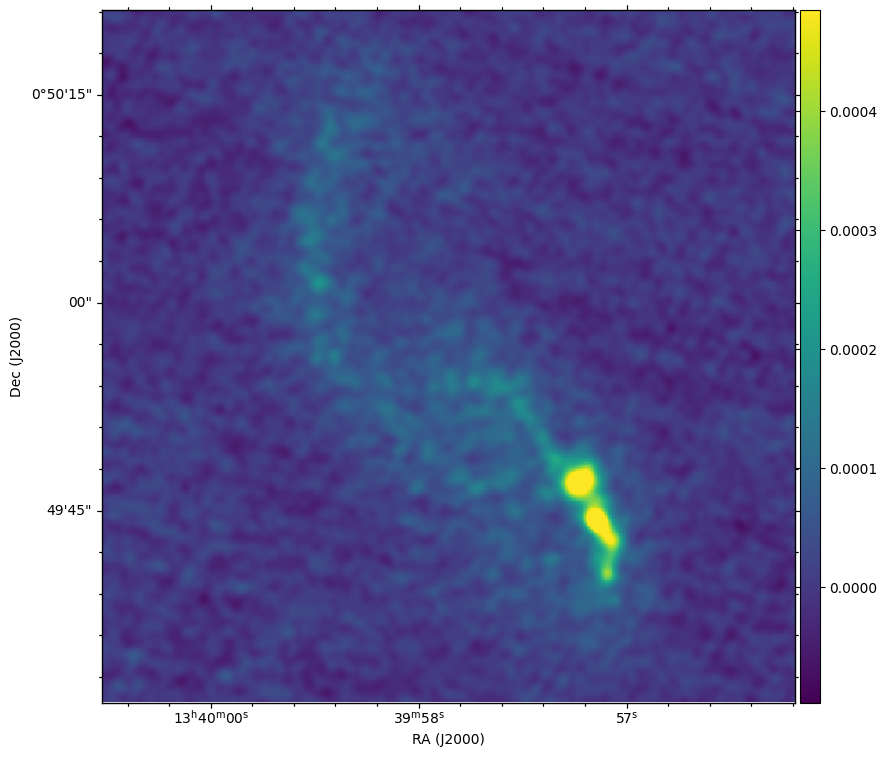

In [ ]:
sDi=aplpy.FITSFigure(image_file)
sDi.show_colorscale()
sDi.add_colorbar()

Checking the data type of `sDi`

In [ ]:
sDi

We can also load the image using the `fits.open` function that corresponds to the astropy package

In [ ]:
image = fits.open(image_file)[0]
image

And we can extract the data from the image, which will show itself as a two dimensional array of pixels with different values for luminosities

In [ ]:
data = image.data
data

array([[-8.42795816e-06, -3.88800254e-06,  8.59378986e-07, ...,
        -1.60543896e-05, -9.20454568e-06, -3.89002980e-06],
       [-6.05034165e-06, -1.99048918e-06,  2.53755479e-06, ...,
        -1.41792461e-05, -7.44180943e-06, -1.89061109e-06],
       [-4.39967926e-06, -6.59264344e-07,  3.81479958e-06, ...,
        -1.35508508e-05, -7.15010765e-06, -1.43404975e-06],
       ...,
       [ 3.28053102e-06,  8.53455276e-06,  1.23046302e-05, ...,
        -1.65220354e-05, -1.59263218e-05, -1.60143027e-05],
       [-4.76962805e-06, -1.61062246e-07,  3.38781524e-06, ...,
        -1.56560654e-05, -1.48928502e-05, -1.47071187e-05],
       [-1.40863476e-05, -1.02853055e-05, -6.93907532e-06, ...,
        -1.26009099e-05, -1.17542404e-05, -1.14344302e-05]], dtype='>f4')

In [ ]:
data.sum()

3.587452

Finally we can take a look to the header, which provides more useful information about the file

In [ ]:
header= image.header
# header

##Noise characterization

For the regions imported we can calculate the average noise, this helps us differentiate from emmision which is positively coming from the source and noise caused by the instrument, atmospheric turbulance and many other factors.

In [ ]:
# from astropy.units.cgs import K

vla_image = fits.getdata(image_file)

region_file = pathd + 'Regions/Regions.reg'
region = pyregion.open(region_file)
region

[Shape : circle ( Number(64.194444),Number(169.75),Number(28.958752) ),
 Shape : circle ( Number(76.694444),Number(91.972222),Number(29.84424) ),
 Shape : circle ( Number(152.38889),Number(78.083333),Number(29.958323) ),
 Shape : circle ( Number(345.44444),Number(433.63889),Number(28.258105) ),
 Shape : circle ( Number(422.52778),Number(389.19444),Number(30.302228) ),
 Shape : circle ( Number(425.30556),Number(294.75),Number(30.097001) )]

In [ ]:
  rms_values = []
  for K in range(len(region)):
    region = pyregion.open(region_file)
    m=len(region)
    del region[0:K]
    del region[1:m]

    mask = region.get_mask(shape=(vla_image.shape[0],vla_image.shape[1]),header=header)
    #mask = get_mask(region,data)
    maskdata= np.multiply(vla_image,mask)
    N=len(maskdata[maskdata!=0])
    rms_values.append(np.sqrt(np.sum(maskdata**2)/N))
  avg_rms = np.mean(rms_values)
  avg_rms

1.8595798640995463e-05

In [ ]:
#maskdata= np.multiply(vla_image,mask[0])
#maskdata[maskdata!=0]
mask[1][mask[1]==True]
mask.shape

(500, 500)

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.


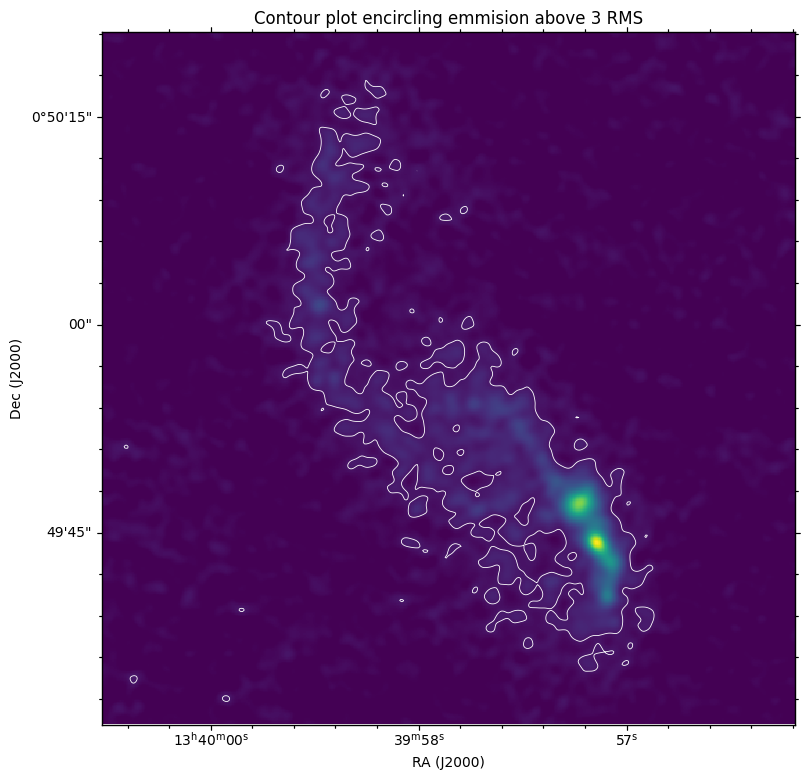

In [ ]:
fig = aplpy.FITSFigure(image_file)
fig.show_colorscale(vmin=0, vmax=np.max(vla_image), stretch='linear')
fig.show_contour(data=vla_image, levels=[3*avg_rms], colors=['white'], linewidths=0.6)
fig.set_title('Contour plot encircling emmision above 3 RMS')

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.


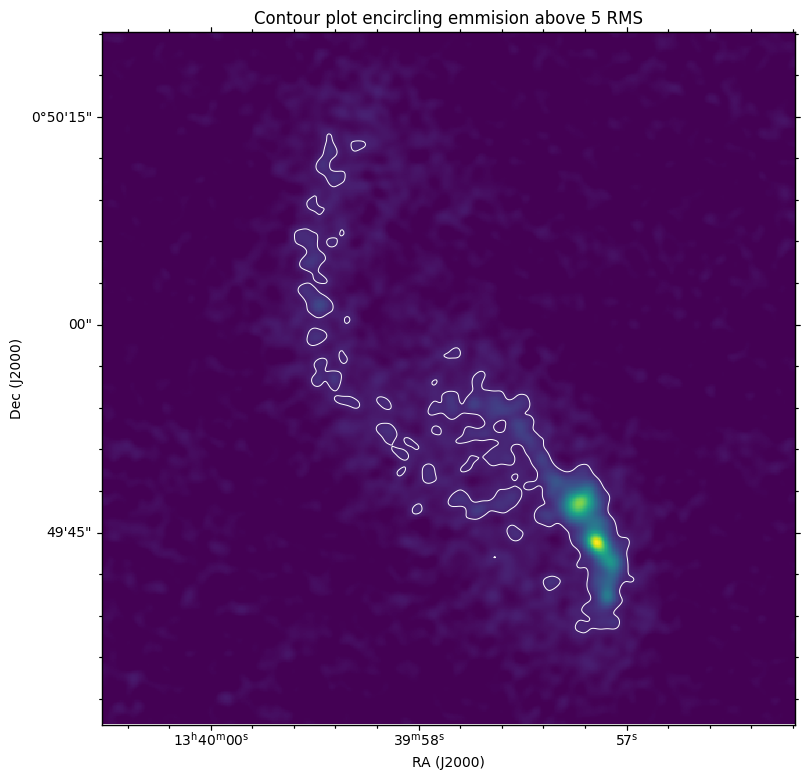

In [ ]:
fig = aplpy.FITSFigure(image_file)
fig.show_colorscale(vmin=0, vmax=np.max(vla_image), stretch='linear')
fig.show_contour(data=vla_image, levels=[5*avg_rms], colors=['white'], linewidths=0.7)
fig.set_title('Contour plot encircling emmision above 5 RMS')

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.


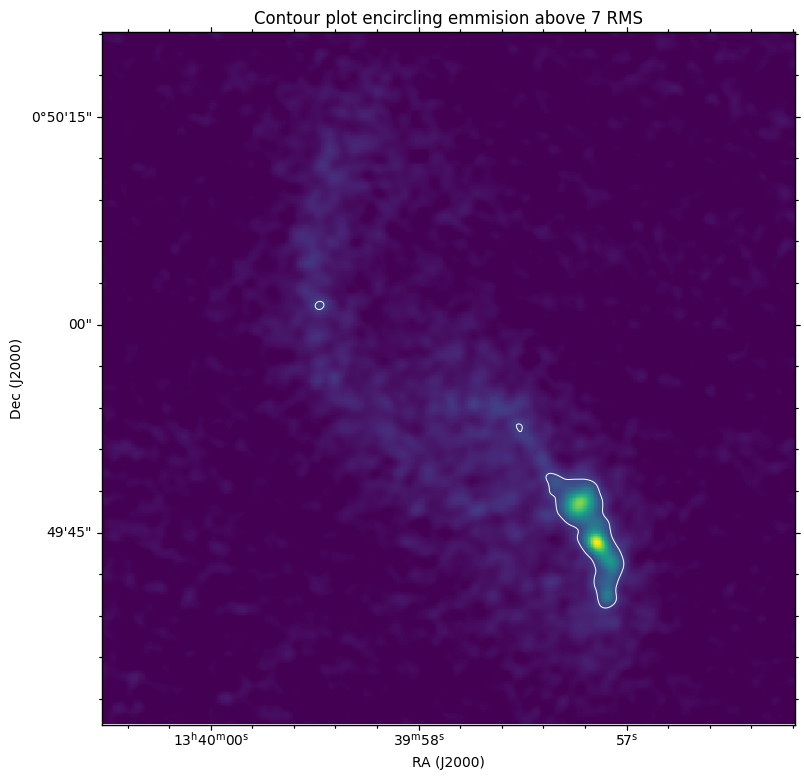

In [ ]:
fig = aplpy.FITSFigure(image_file)
fig.show_colorscale(vmin=0, vmax=np.max(vla_image), stretch='linear')
fig.show_contour(data=vla_image, levels=[10*avg_rms], colors=['white'], linewidths=0.7)
fig.set_title('Contour plot encircling emmision above 7 RMS')

##Photometry

Photometry refers to the process of measuring the intensity or brighntess of a source by means of capturing the radiation coming from the source

In [ ]:
# bmaj, bmin and cdelt1 from the header
bmaj_deg = header['BMAJ']
bmin_deg = header['BMIN']
pixel_size_deg = header['CDELT1']

# Area of the beam in square degrees
area_deg2 = np.pi * bmaj_deg * bmin_deg / (4 * np.log(2))

# Area from square degrees to square pixels
pixel_area_deg2 = pixel_size_deg**2
area_pixels = area_deg2 / pixel_area_deg2

print("Area of the beam in pixels:", area_pixels)

Area of the beam in pixels: 113.30900354567986


In [ ]:
# Significant pixels are the ones with emission above 3-sigma (3 times the rms)
significant_pixels = vla_image[vla_image > 3 * avg_rms]

# Total emission in Jy by summing the significant pixels
total_emission_jy = np.sum(significant_pixels)

print("Total emission of the galaxy in Jy:", total_emission_jy)


Total emission of the galaxy in Jy: 3.0008967


Calculating luminosities as a way of measuring how much energy per unit time hits a detector is also a useful excercise in astronomy, this calculation depends on many variables:

In [ ]:
distance_parsecs=98e6

distance_cm= distance_parsecs*3.086e18

total_emission_erg= (total_emission_jy/area_pixels)*1e-23

solarluminosity= 3.827e33
total_luminosity_solar= total_emission_erg*4*np.pi*distance_cm**2/solarluminosity

print("Total luminosity in solar luminosities:",total_luminosity_solar)

Total luminosity in solar luminosities: 7.953934698838102e-05


In [ ]:
#total_emission_erg
total_emission_jy/area_pixels

0.0264841857078569

## Working with Data Cubes

A data cube is a multi dimensional array of data. In this case a 3-dimensional array containing spatial information (galactic right ascension and declination)on two of its axes and spectral information on the third one. This allows us to visualize the emmision at different frequencies coming from one single object.

In order to work with a data cube first, we read the cube and extract the header and data from it

In [ ]:
image2= fits.open('/content/drive/MyDrive/Imaging Codes/Galaxyfits/NGC_5258_cube_1arcsec_inregion.pbcor_hcorr.fits')[0]
image2

#data and header
cube_data = image2.data
cube_header = image2.header

In order to understand the dimensions of the cube, we can print the shape of the data cube which will be displayes in pixels.

In [ ]:
print(cube_data.shape)  # (n_channels, n_y_pixels, n_x_pixels)

n_channels = cube_header['NAXIS3']
n_y_pixels = cube_header['NAXIS2']
n_x_pixels = cube_header['NAXIS1']

(250, 500, 500)


Print the full header

In [ ]:
print(cube_header)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                  500                                                  NAXIS2  =                  500                                                  NAXIS3  =                  250                                                  BMAJ    =   0.0002777777777778                                                  BMIN    =   0.0002777777777778                                                  BPA     =                  0.0                                                  BTYPE   = 'Intensity'                                                           OBJECT  = 'NGC_5258'                                                            BUNIT   = 'Jy/beam '                                                            RADESYS = 'ICRS    '                    

Check the data on the cube

In [ ]:
cube_data[1,:,:]

array([[       nan,        nan,        nan, ..., 0.02904355, 0.03236155,
        0.03454045],
       [       nan,        nan,        nan, ..., 0.03176667, 0.03614488,
        0.03919604],
       [       nan,        nan,        nan, ..., 0.03324928, 0.03850854,
        0.04231478],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype='>f4')

In [ ]:
V_d        = (1-cube_header['CRVAL3']/cube_header['RESTFRQ'])*2.99999e5                                                   #converts central freq to velocity
V_u        = (1-(cube_header['CRVAL3']+cube_header['CDELT3']*cube_header['NAXIS3'])/cube_header['RESTFRQ'])*2.99999e5     # calculates the lower frequency
deltaV     = (V_u-V_d)/cube_header['NAXIS3']

In [ ]:
V_d, V_u, deltaV

(5548.820227517398, 6799.681414953371, 5.003444749743893)

We can visualize data cube channels by just changing the `channel index` parameter, this is of course limited to the number of channels in the data cube given by the variable `n_channels`

In [ ]:
print('The number of channels in the data cube is: ' + str(n_channels))

The number of channels in the data cube is: 250


Let's visualize a slice of the cube at channel 90

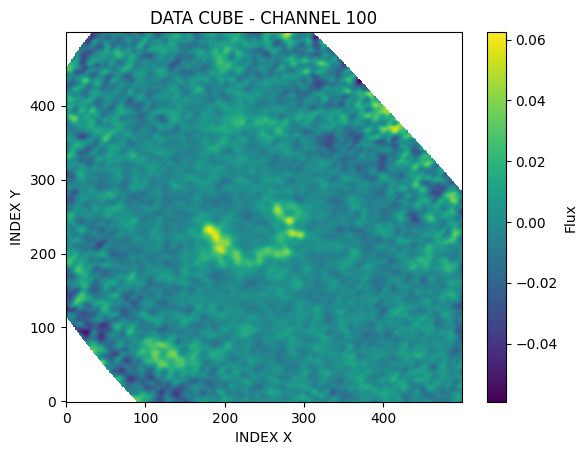

In [ ]:
channel_index = 90
plt.imshow(cube_data[channel_index], origin='lower', cmap='viridis', aspect='auto')

#set labels
plt.xlabel('INDEX X')
plt.ylabel('INDEX Y')
plt.title(f'DATA CUBE - CHANNEL {channel_index}')

#show the figure of cube
plt.colorbar(label='Flux')

Here we can see part of the emmision originating from galaxy at the corresponding velocity at that slice

Now we use the apertures created in ds9 as regions, generate a profile for each region and create a plot for each one.

In [ ]:
from astropy.units.cgs import K

image_cube = '/content/drive/MyDrive/Imaging Codes/Galaxyfits/NGC_5258_cube_1arcsec_inregion.pbcor_hcorr.fits'
vla_cube = fits.getdata(image_cube)

region_cube = pathd + 'Regions/guide_2Dimage'
region1 = pyregion.open(region_cube)
region1

[Shape : circle ( Number(167),Number(320),Number(20) ),
 Shape : circle ( Number(360),Number(125),Number(20) ),
 Shape : circle ( Number(342),Number(160),Number(20) ),
 Shape : circle ( Number(249),Number(224),Number(20) ),
 Shape : circle ( Number(305),Number(210),Number(20) ),
 Shape : circle ( Number(188),Number(265),Number(20) ),
 Shape : circle ( Number(164),Number(385),Number(20) )]

## Emission Lines

Extract header information about frequency

In [ ]:
frequency = cube_header['CRVAL3'] + (np.arange(cube_header['NAXIS3']) - cube_header['CRPIX3'] + 1) * cube_header['CDELT3']

Regions coordinates

In [ ]:
x, y, radius = 167, 320, 20

x1,y1,radius1= 360, 125, 20

x2,y2,radius2= 342, 160, 20

x3,y3,radius3= 249,224,20

x4,y4,radius4= 305,210,20

x5,y5,radius5= 188,265,20

x6,y6,radius6= 164,385,20

Define functions for creating a circular mask, calculating the emission lines and plotting them

In [ ]:
def generate_circular_mask(shape, center_x, center_y, radius):
    y, x = np.ogrid[:shape[0], :shape[1]]
    masko = (x - center_x)**2 + (y - center_y)**2 <= radius**2
    return masko

def calculate_emission_line(masko):
    spectrum = np.nanmean(vla_cube[:, masko], axis=1)
    return frequency, spectrum

def plot_emission_line(region, frequency, spectrum):
    plt.figure(figsize=(8, 5))
    plt.plot(frequency, spectrum, label='Region {}'.format(region))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Flux Density (K)')
    plt.title('Emission Line Profile for {}'.format(region))
    plt.legend()
    plt.grid()
    plt.show()

Generate the mask for the region of interest

In [ ]:
masko = generate_circular_mask(vla_cube.shape[1:], x, y, radius)
masko1 = generate_circular_mask(vla_cube.shape[1:], x1, y1, radius1)
masko2= generate_circular_mask(vla_cube.shape[1:], x2, y2, radius2)
masko3 = generate_circular_mask(vla_cube.shape[1:], x3, y3, radius3)
masko4 = generate_circular_mask(vla_cube.shape[1:], x4, y4, radius4)
masko5 = generate_circular_mask(vla_cube.shape[1:], x5, y5, radius5)
masko6 = generate_circular_mask(vla_cube.shape[1:], x6, y6, radius6)

Calculate and plot the emission line for the region of interest

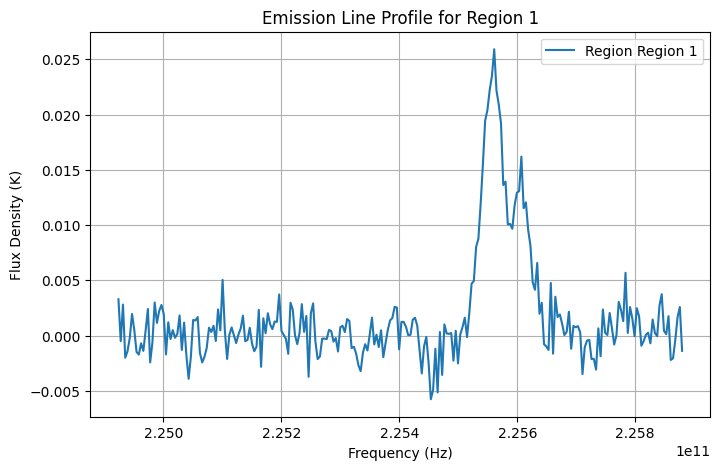

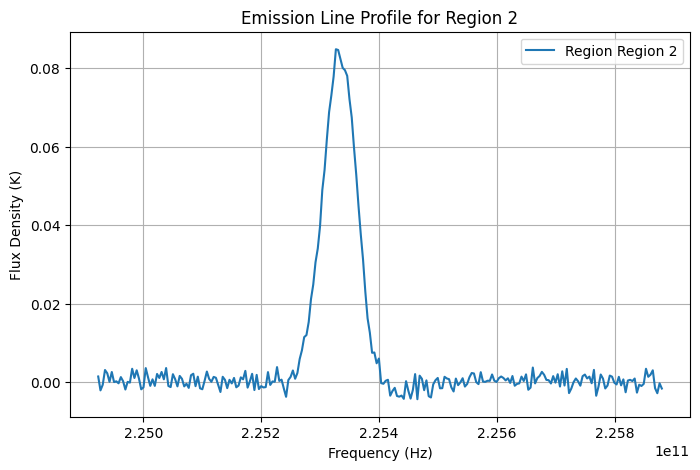

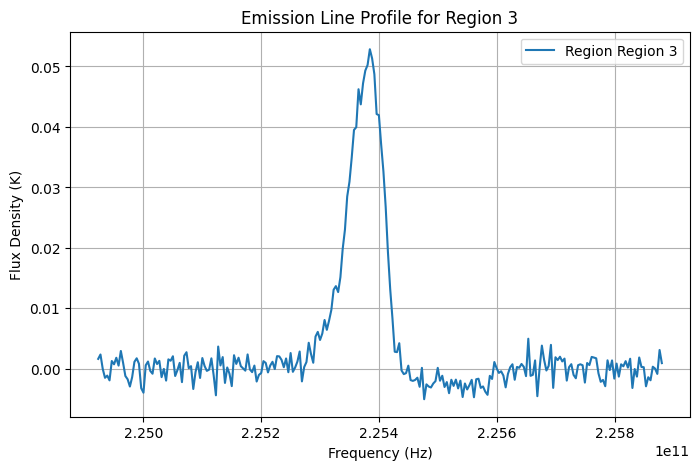

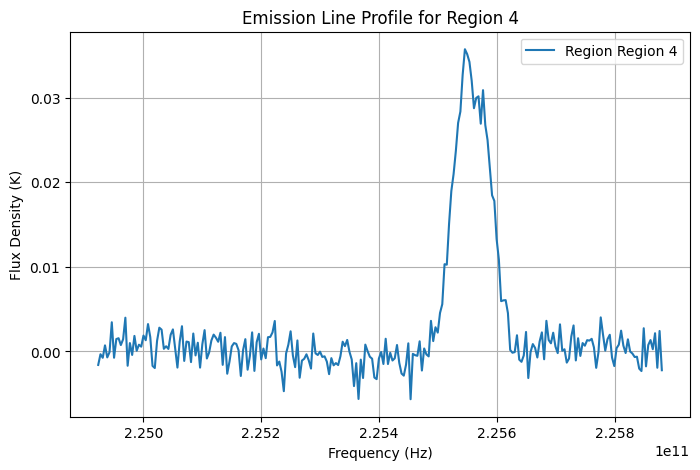

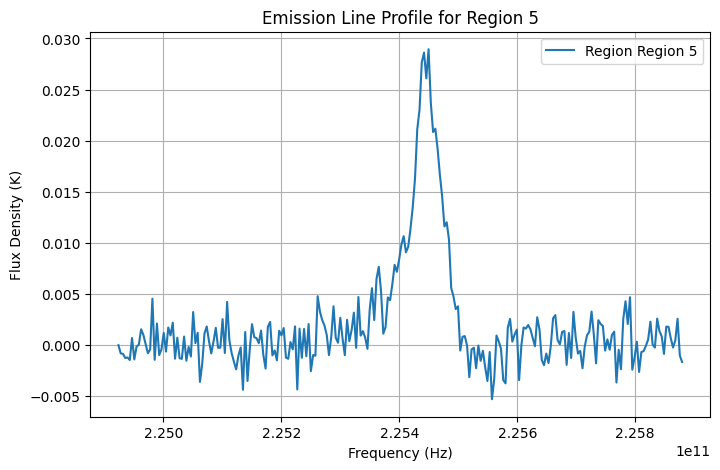

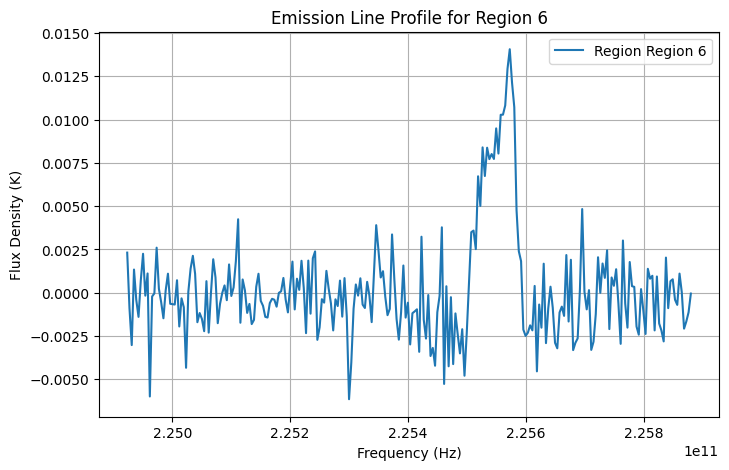

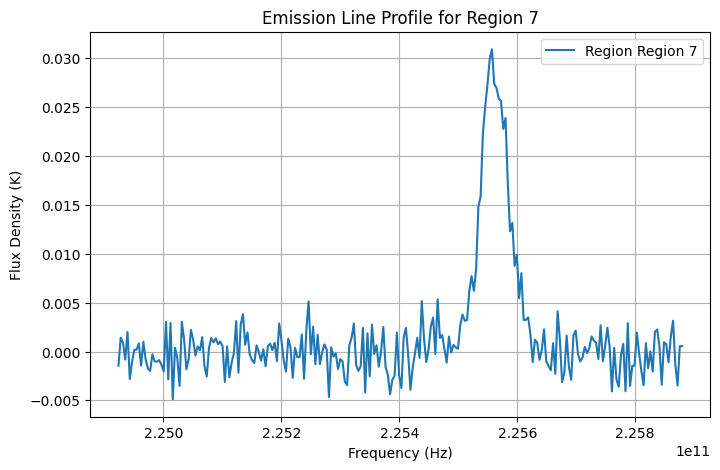

In [ ]:
frequency, spectrum = calculate_emission_line(masko)
plot_emission_line('Region 1', frequency, spectrum)

frequency, spectrum = calculate_emission_line(masko1)
plot_emission_line('Region 2', frequency, spectrum)

frequency, spectrum = calculate_emission_line(masko2)
plot_emission_line('Region 3', frequency, spectrum)

frequency, spectrum = calculate_emission_line(masko3)
plot_emission_line('Region 4', frequency, spectrum)

frequency, spectrum = calculate_emission_line(masko4)
plot_emission_line('Region 5', frequency, spectrum)

frequency, spectrum = calculate_emission_line(masko5)
plot_emission_line('Region 6', frequency, spectrum)

frequency, spectrum = calculate_emission_line(masko6)
plot_emission_line('Region 7', frequency, spectrum)

## Moment Maps


Creating a function to calculate the rms

In [ ]:
def rms_function(array):
    N = len(array)
    rms = np.sqrt(np.sum(array**2)/N)
    return rms

Creating a function to do the clipping

In [ ]:
def clipper(array,rms, pb_mask):
    clipped_array = np.zeros([array.shape[0],array.shape[1],array.shape[2]])
    for k in range(0,array.shape[0],1):
        array[k,:,:] = np.multiply(pb_mask,array[k,:,:])
        for i in range(0,array.shape[1],1):
            for j in range(0,array.shape[2],1):
                if array[k,i,j] >= rms:
                    clipped_array[k,i,j] = array[k,i,j]
                else:
                    clipped_array[k,i,j] = 0
    return clipped_array

Creating a function that returns the moments

In [ ]:
def moments(cube,factor, pb_mask):
    cube_data    = cube.data
    header       = cube.header
    cube_data    = np.nan_to_num(cube_data)
    del header['HISTORY']

    v = cube_data.shape[0]
    x = cube_data.shape[1]
    y = cube_data.shape[2]
    V_d        = (1-header['CRVAL3']/header['RESTFRQ'])*2.99999e5                                         #converts central freq to velocity
    V_u        = (1-(header['CRVAL3']+header['CDELT3']*header['NAXIS3'])/header['RESTFRQ'])*2.99999e5     # calculates the lower frequency
    deltaV     = (V_u-V_d)/header['NAXIS3']

    slice_1    = cube_data[4,:,:]
    slice_2    = cube_data[-4,:,:]

    # npixels =

    rms        = 0.5*(rms_function(slice_1)+rms_function(slice_2))    #correct dividing by no of pixels in a beam

    cube_data  = clipper(cube_data,factor*0.008,pb_mask)

    v_axis     = np.linspace(0,v-1,v,dtype=int)
    M0   = np.zeros([x,y])
    M1   = np.zeros([x,y])
    M2   = np.zeros([x,y])
    vl   = np.linspace(V_d,V_u,v)
    for i in range(0,x,1):
        for j in range(0,y,1):
            M0[i,j] = scipy.integrate.simps(cube_data[:,i,j],v_axis)*deltaV
            M1[i,j] = (scipy.integrate.simps(vl*cube_data[:,i,j],v_axis)*deltaV)/M0[i,j]
            M2[i,j] = np.sqrt((scipy.integrate.simps(cube_data[:,i,j]*(vl-M1[i,j])**2,v_axis)*deltaV)/M0[i,j])


    new_header          = header
    new_header['NAXIS'] = 2
    del new_header['NAXIS3']
    del new_header['CTYPE3']
    del new_header['CRVAL3']
    del new_header['CDELT3']
    del new_header['CRPIX3']
    del new_header['CUNIT3']
    del new_header['PC4_1']
    del new_header['PC4_2']
    del new_header['PC1_4']
    del new_header['PC2_4']
    del new_header['PC4_4']

    mom_0 = fits.PrimaryHDU(M0.astype('float'), new_header)
    mom_1 = fits.PrimaryHDU(M1.astype('float'), new_header)
    mom_2 = fits.PrimaryHDU(M2.astype('float'), new_header)
    return mom_0,mom_1,mom_2

Creating a mask around the galaxy in order to get rid of the noisy edges

In [ ]:
import pyregion
a = """image \npolygon({},{},{},{},{},{},{},{},{},{},{},{},{},{})""".format(72,379, 72,212,228,8,452 ,8, 452,245, 215,489,121,489 )
region = []
region.append(a)
r = pyregion.parse(region[0])
envelope_mask      = r.get_mask(shape=[500, 500])

Calculating the moments from the fits file

In [ ]:
import scipy as sp
import scipy.ndimage
cube         = fits.open('/content/drive/MyDrive/Imaging Codes/Galaxyfits/NGC_5258_cube_1arcsec_inregion.pbcor_hcorr.fits')[0]
moment_0, moment_1, moment_2 = moments(cube,5,envelope_mask)

<ipython-input-40-6302a2d5f9f9>:30: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  M0[i,j] = scipy.integrate.simps(cube_data[:,i,j],v_axis)*deltaV
<ipython-input-40-6302a2d5f9f9>:31: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  M1[i,j] = (scipy.integrate.simps(vl*cube_data[:,i,j],v_axis)*deltaV)/M0[i,j]
<ipython-input-40-6302a2d5f9f9>:31: RuntimeWarning: invalid value encountered in scalar divide
  M1[i,j] = (scipy.integrate.simps(vl*cube_data[:,i,j],v_axis)*deltaV)/M0[i,j]
<ipython-input-40-6302a2d5f9f9>:32: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  M2[i,j] = np.sqrt((scipy.integrate.simps(cube_data[:,i,j]*(vl-M1[i,j])**2,v_axis)*deltaV)/M0[i,j])


Plotting the moments

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.
INFO:astropy:Auto-setting vmin to -8.861e-01
INFO:astropy:Auto-setting vmax to  9.836e+00


INFO: Auto-setting vmin to -8.861e-01 [aplpy.core]
INFO: Auto-setting vmax to  9.836e+00 [aplpy.core]


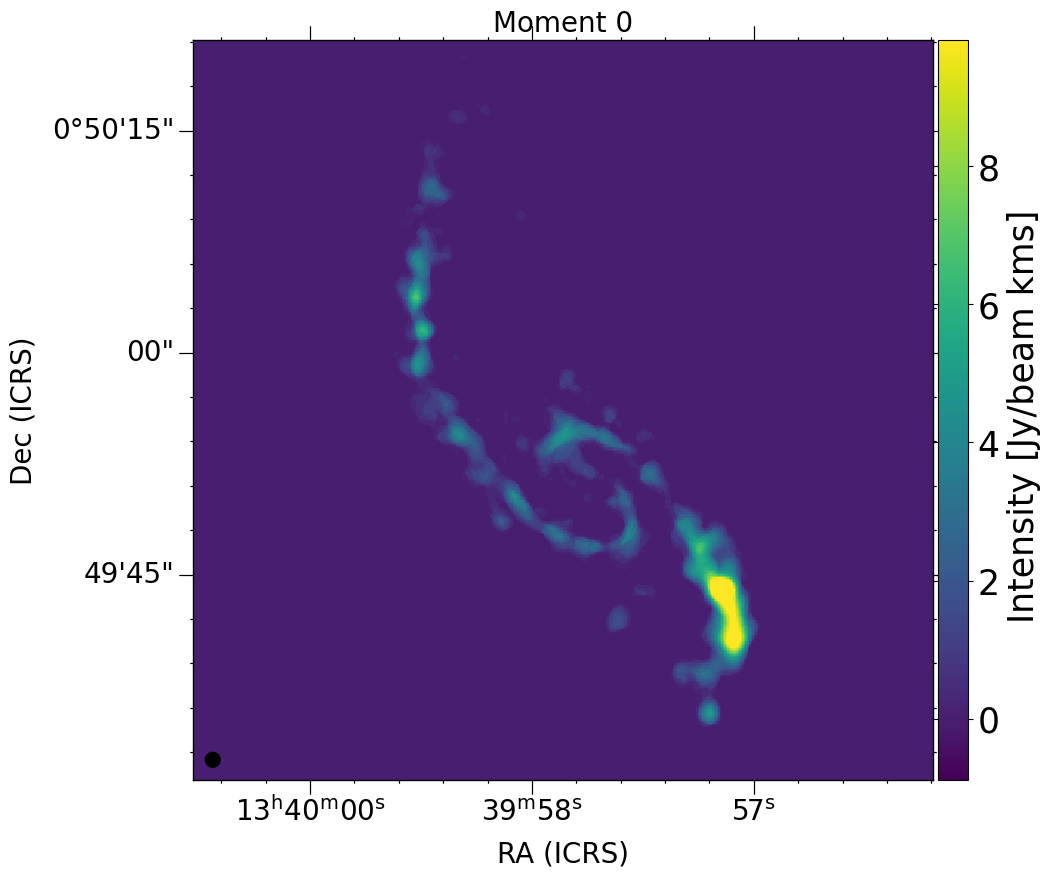

In [ ]:
fig = aplpy.FITSFigure(moment_0, figsize=(10, 10))
fig.set_title('Moment 0',fontsize=20)
fig.show_colorscale(cmap='viridis')
fig.add_colorbar()
fig.colorbar.set_location('right')
fig.colorbar.set_width(0.3)
fig.colorbar.set_font(size='25')
fig.colorbar.set_axis_label_text('Intensity [Jy/beam kms] ')
fig.colorbar.set_axis_label_font(size=25)
fig.axis_labels.set_font(size=20)
fig.tick_labels.set_font(size=20)
fig.ticks.set_length(10)
fig.add_beam()
fig.beam.set_color('black')

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


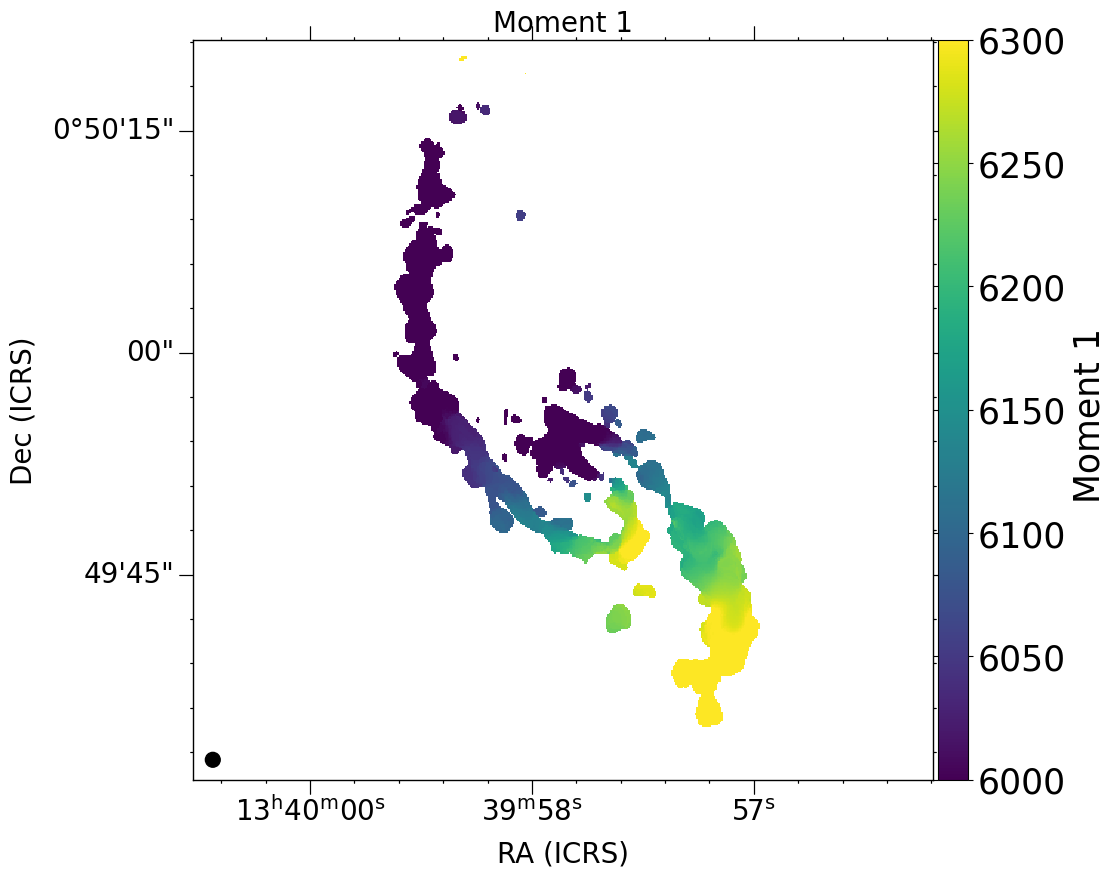

In [ ]:
fig = aplpy.FITSFigure(moment_1, figsize=(10, 10))
fig.set_title('Moment 1',fontsize=20)
fig.show_colorscale(cmap='viridis',vmin=6000,vmax = 6300)
fig.add_colorbar()
fig.colorbar.set_location('right')
fig.colorbar.set_width(0.3)
fig.colorbar.set_font(size='25')
fig.colorbar.set_axis_label_text('Moment 1 ')
fig.colorbar.set_axis_label_font(size=25)
fig.axis_labels.set_font(size=20)
fig.tick_labels.set_font(size=20)
fig.ticks.set_length(10)
fig.add_beam()
fig.beam.set_color('black')

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


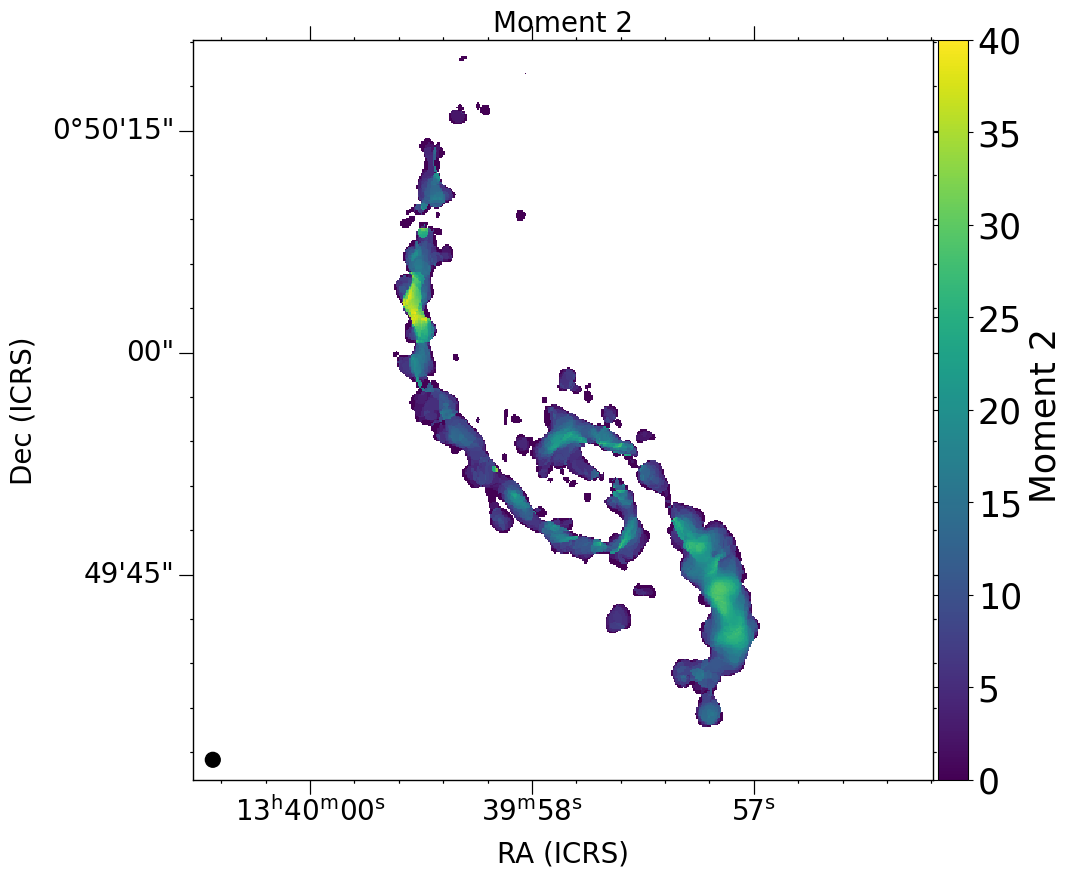

In [ ]:
fig = aplpy.FITSFigure(moment_2, figsize=(10, 10))
fig.set_title('Moment 2',fontsize=20)
fig.show_colorscale(cmap='viridis',vmin=0,vmax = 40)
fig.add_colorbar()
fig.colorbar.set_location('right')
fig.colorbar.set_width(0.3)
fig.colorbar.set_font(size='25')
fig.colorbar.set_axis_label_text('Moment 2 ')
fig.colorbar.set_axis_label_font(size=25)
fig.axis_labels.set_font(size=20)
fig.tick_labels.set_font(size=20)
fig.ticks.set_length(10)
fig.add_beam()
fig.beam.set_color('black')